In [1]:
import json
import pprint
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from IPython.display import display
from matplotlib.lines import Line2D
from sqlalchemy import create_engine

engine = create_engine("sqlite:///project2.sqlite")

# DATA EXTRACTION

### UK Data Extraction via .csv File(s) and Transformation

In [2]:
df = pd.read_csv("uk_data.csv")
df.columns = ["Date","Number"]
df.dropna(inplace=True)

df.drop([2,3,5], inplace=True)

df.reset_index(drop=True,inplace=True)
df.set_index("Date")

# Data tansformation from .csv file. Taking data in dictionaries and adding a new column with only year, in order to be
# able to 'groupby' in coming steps.
df['Number'] = [int(num) for num in df['Number']]
df['year'] = [dt[-2:] for dt in df.Date]

# Groupping and summing by the newly added column to get total number of crimes per year.
gpb = df.groupby('year').sum()

# Removing the last year to match the year in other countries crime datasets.
gpb = gpb[:-1]
display(gpb)

,Number
year,
15,3402114
16,4814467
17,5457761
18,5835033
19,6090632


In [ ]:
'''
ddd = df.Date[-2:].dt.year
v = [dt[-2:] for dt in df.Date]
print(v)
'''

In [3]:
# Worldometer wouldn't authorise data scraping (403 error) so using Wiki instead
url = "https://en.wikipedia.org/wiki/Demography_of_the_United_Kingdom#Population"
tables = pd.read_html(url)
df = tables[18]
df = df[115:120]

In [4]:
uk_pop_df = df[["Unnamed: 0", "Average population[42]"]]
uk_pop_df.columns = ["Date", "Population"]
uk_pop_df["Date"] = uk_pop_df["Date"].astype(str)
uk_pop_df["year"] = [dt[-2:] for dt in uk_pop_df.Date]
uk_pop_df = uk_pop_df[["Population", "year"]]
uk_pop_df = uk_pop_df.set_index("year")

uk_pop_df

<ipython-input-4-745efe018ffb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_pop_df["Date"] = uk_pop_df["Date"].astype(str)
<ipython-input-4-745efe018ffb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_pop_df["year"] = [dt[-2:] for dt in uk_pop_df.Date]


,Population
year,
15,65110000.0
16,65648000.0
17,66040200.0
18,66436000.0
19,66797000.0


In [5]:
gpb = gpb.merge(uk_pop_df, how = "outer", left_index = True, right_index = True)
gpb["Rate per 100,000"] = gpb["Number"]/gpb["Population"]*100000
gpb

,Number,Population,"Rate per 100,000"
year,,,
15,3402114,65110000.0,5225.178928
16,4814467,65648000.0,7333.760358
17,5457761,66040200.0,8264.301138
18,5835033,66436000.0,8782.938467
19,6090632,66797000.0,9118.122071


**UK Data Report**

The UK crime data was read in via a csv which can be found here: https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/bulletins/crimeinenglandandwales/yearendingjune2020#:~:text=The%20police%20recorded%205.8%20million,July%202019%20to%20March%202020.&text=Overall%2C%20theft%20offences%20fell%20by,the%20year%20ending%20June%202020
Once loaded, irrelevant rows had to be dropped and the date set as the index. Since the date was recorded quarterly with the date column as a string only the last two elements of the string (i.e. the part of the string containing the year) were kept and the groupby and sum functions were used to combine quarterly crime counts into a yearly total.

Following this, population data for the UK was scraped from wikipedia (https://en.wikipedia.org/wiki/Demography_of_the_United_Kingdom#Population) using the pd.read_html method (the official worldometer could not be used because they do not allow data to be scraped from their website (403 error)). This population data was then filtered so that only the population values in the UK for each year for which we had crime data was present, then the date was set as the index of this dataframe and the format of the date was changed to match that of the UK crime (gpb) dataframe allowing the two dataframes to be merged on their shared index. Formatting the date column in the population dataframe involved setting the data type to string and then once again dropping all but the last two characters in that string.

Finally, a simple calaculation was used (total_crime X 100,000 / population) on each row to calculate the rate of crime per 100,000 people, which is a standard used to compare crime rates across different countries.

### Canada Data Extraction via Scraping and Transformation

In [6]:
url = "https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017701"
tables = pd.read_html(url)
df = tables[0]
df.columns = ["statistics", "2015", "2016", "2017", "2018", "2019"]
df  = df.T

In [7]:
#Select relevant columns
can_df = df[[1, 3]]
can_df.columns  = ["Number", "Rate per 100,000"]
can_df = can_df[1:]
can_df["Number"] = can_df["Number"].astype(np.int64)
can_df["Rate per 100,000"] = can_df["Rate per 100,000"].astype(float)
can_df["Population"] = round(can_df["Number"] * 100000 / can_df["Rate per 100,000"], 0)
can_df["Population"] = can_df["Population"].astype(np.int64)
can_df

,Number,"Rate per 100,000",Population
2015,2118681,5934.20,35702892
2016,2161927,5987.14,36109511
2017,2213293,6056.63,36543309
2018,2280328,6153.44,37057776
2019,2438518,6487.27,37589279


**Canadian Data Report**

Data for Canadian crime was scraped from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017701 using the pd.read_html method. As this table was set upon the opposite axis to how we would be using it the columns, which would become our rows, were renamed as this would later become the index. The table was then transposed and the relevant columns were selected and once again renamed, this time to give column headers and finally, the row at index 0 was then dropped as this contained a second row of column headers.

Since this data set already had the crime rate per 100,000 people a formula was used to obtain the population data (population = total_crime X 100,000 / rate_per_100,000) to do this the data types had to be converted from string to float for rate, and from string to int64 (large integer) for total crime and population. This method for obtaining the population data was chosen over further data scraping because it accounts for small descrepancies in the recorded population that may arise from using a different source to the Canadian government; with this method our population value is the same as that used by the Canadian government when they performed their rate calculations.

### US Data Extraction via Scraping and Transformation

In [8]:
url = "http://www.disastercenter.com/crime/uscrime.htm"
tables = pd.read_html(url)
df = tables[1]
df_number = df[72:77]
df_number.reset_index(inplace = True)

df_rate = df[149:154]
df_rate.reset_index(inplace = True)

In [9]:
df_rate = df_rate[[0, 2]]
df_rate.columns = ["Date", "Rate per 100,000"]

In [10]:
df_number = df_number[[0, 2]]
df_number.columns = ["Date", "Number"]

In [11]:
us_df = df_number.merge(df_rate, how = "outer")
us_df

,Date,Number,"Rate per 100,000"
0,2015,9258298,2885.1
1,2016,9214136,2849.1
2,2017,8966863,2757.8
3,2018,8471483,2593.2
4,2019,8171087,2489.3


In [12]:
us_df["Number"] = us_df["Number"].astype(np.int64)
us_df["Rate per 100,000"] = us_df["Rate per 100,000"].astype(float)
us_df["Population"] = round(us_df["Number"] * 100000 / us_df["Rate per 100,000"], 0)
us_df["Population"] = us_df["Population"].astype(np.int64)
us_df

,Date,Number,"Rate per 100,000",Population
0,2015,9258298,2885.1,320900419
1,2016,9214136,2849.1,323405145
2,2017,8966863,2757.8,325145515
3,2018,8471483,2593.2,326680665
4,2019,8171087,2489.3,328248383


**US Data Report**

The US crime data was scraped from http://www.disastercenter.com/crime/uscrime.htm using the pd.read_html method. Due to the formatting of this table, a dataframe for rate and a dataframe for total number of crimes had to be created seperately (rate and number were in the same column). To do this the rows corresponding to number at the required dates and the rows corresponding to rate at the required dates were used to create two small dataframes. Each of these dataframes then had irrelevant columns dropped and had their column headers renamed. A merge was then performed on the date so that number and rate were now consolidated into one dataframe.

As with the Canadian data, the rate per 100,000 and total number of crime values were used to obtain the US population for each year.

### Australian Data Extraction via Scraping and Transformation

In [13]:
aus_url = "https://www.abs.gov.au/statistics/people/crime-and-justice/recorded-crime-offenders/2019-20"
page = requests.get(aus_url)
aus_soup = BeautifulSoup(page.text, 'html.parser')

We indexed Australian dataset (from thousands to millions) in order to match it with the other datasets i.e. US, UK and Canada.

In [14]:
aus_scrp = aus_soup.find_all("table")
aa = aus_scrp[0].find_all('th')
bb = aus_scrp[0].find_all('td')
data = {'Date':[],'Numbers':[]}
for year, number in zip(aa[-5:],bb[-5:]):
    data['Date'].append(year.text)
    data['Numbers'].append(int(number.text.replace(',','')))    

aus_data = pd.DataFrame(data)
display(aus_data)

,Date,Numbers
0,2015-16,64014
1,2016-17,61198
2,2017-18,61237
3,2018-19,53583
4,2019-20,40975


**Australian Data Report**

The Australian crime data was scraped from "https://www.abs.gov.au/statistics/people/crime-and-justice/recorded-crime-offenders/2019-20" using the "BeautifulSoup" method. There were a couple of limitations regarding Australian data:
1. The crime data is available for a particular type of crime, not all crimes in general;
2. The crime data is not available on the national level, rather it was available on the state-level so, we performed two transformations for the Australian data: indexed the data (from thousands to millions) in order to match it with the other datasets i.e. US, UK and Canada; and, added the state-level data to convert it to national data.

### Combined Crime Record: US, UK, Canada & Australia

In [15]:
data = us_df[["Date", "Number", "Rate per 100,000"]]
data.columns = ['Date','US Total', "US Rate per 100,000"]
data['Australia Total'] = list(aus_data['Numbers'])
data['Canada Total'] = list(can_df['Number'])
data['Canada Rate per 100,000'] = list(can_df['Rate per 100,000'])
data['UK Total'] = list(gpb['Number'])
data['UK Rate per 100,000'] = list(gpb['Rate per 100,000'])

display(data)

,Date,US Total,"US Rate per 100,000",Australia Total,Canada Total,"Canada Rate per 100,000",UK Total,"UK Rate per 100,000"
0,2015,9258298,2885.1,64014,2118681,5934.20,3402114,5225.178928
1,2016,9214136,2849.1,61198,2161927,5987.14,4814467,7333.760358
2,2017,8966863,2757.8,61237,2213293,6056.63,5457761,8264.301138
3,2018,8471483,2593.2,53583,2280328,6153.44,5835033,8782.938467
4,2019,8171087,2489.3,40975,2438518,6487.27,6090632,9118.122071


**Combined Data Report**

To create a combined dataframe to compare the crime in each country the US dataframe was used as a starting point. First the population data was removed as this was not seen as being directly relevant to the comparison wherein the most important data is the crime rate of each country. Then the total crime and crime rates of Canada and the UK were added to this dataframe to give the dataframe seen above.

# DATA LOADING

In [16]:
data.to_sql("combined_data", engine, if_exists = 'replace')
gpb.to_sql("UK_data", engine, if_exists = 'replace')
can_df.to_sql("Canada_data", engine, if_exists = 'replace')
us_df.to_sql("US_data", engine, if_exists = 'replace')
aus_data.to_sql("AUS_data", engine, if_exists = 'replace')

In [17]:
pd.read_sql("SELECT * FROM combined_data", engine)

,index,Date,US Total,"US Rate per 100,000",Australia Total,Canada Total,"Canada Rate per 100,000",UK Total,"UK Rate per 100,000"
0,0,2015,9258298,2885.1,64014,2118681,5934.20,3402114,5225.178928
1,1,2016,9214136,2849.1,61198,2161927,5987.14,4814467,7333.760358
2,2,2017,8966863,2757.8,61237,2213293,6056.63,5457761,8264.301138
3,3,2018,8471483,2593.2,53583,2280328,6153.44,5835033,8782.938467
4,4,2019,8171087,2489.3,40975,2438518,6487.27,6090632,9118.122071


In [18]:
pd.read_sql("SELECT * FROM UK_data", engine)

,year,Number,Population,"Rate per 100,000"
0,15,3402114,65110000.0,5225.178928
1,16,4814467,65648000.0,7333.760358
2,17,5457761,66040200.0,8264.301138
3,18,5835033,66436000.0,8782.938467
4,19,6090632,66797000.0,9118.122071


In [19]:
pd.read_sql("SELECT * FROM Canada_data", engine)

,index,Number,"Rate per 100,000",Population
0,2015,2118681,5934.20,35702892
1,2016,2161927,5987.14,36109511
2,2017,2213293,6056.63,36543309
3,2018,2280328,6153.44,37057776
4,2019,2438518,6487.27,37589279


In [20]:
pd.read_sql("SELECT * FROM US_data", engine)

,index,Date,Number,"Rate per 100,000",Population
0,0,2015,9258298,2885.1,320900419
1,1,2016,9214136,2849.1,323405145
2,2,2017,8966863,2757.8,325145515
3,3,2018,8471483,2593.2,326680665
4,4,2019,8171087,2489.3,328248383


In [21]:
pd.read_sql("SELECT * FROM AUS_data", engine)

,index,Date,Numbers
0,0,2015-16,64014
1,1,2016-17,61198
2,2,2017-18,61237
3,3,2018-19,53583
4,4,2019-20,40975


**SQL Database Report**

Both the combined dataframe and the individual dataframe from each country were loaded into the SQL database.

# VISUALIZATIONS

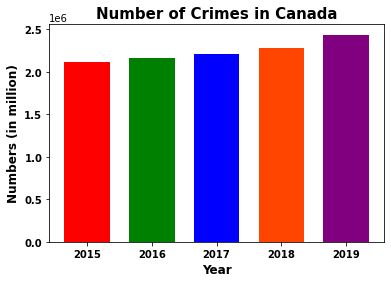

In [22]:
# Canada
plt.figure()
plt.bar(data['Date'], data['Canada Total'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Numbers (in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in Canada', fontsize = 15, fontweight = 'bold')
plt.show()

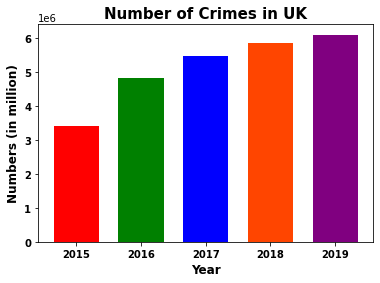

In [23]:
# UK
plt.figure()
plt.bar(data['Date'], data['UK Total'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Numbers (in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in UK', fontsize = 15, fontweight = 'bold')
plt.show()

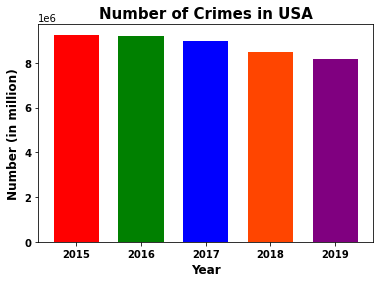

In [24]:
# USA
plt.figure()
plt.bar(data['Date'],data['US Total'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Number (in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in USA', fontsize = 15, fontweight = 'bold')
plt.show()

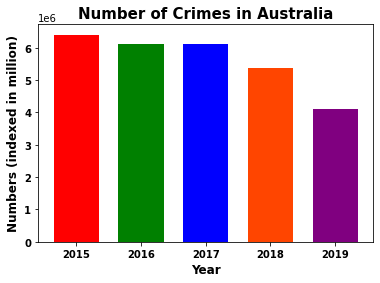

In [25]:
# Australia
plt.figure()
data['Australia'] = data['Australia Total'] * 100
plt.bar(data['Date'], data['Australia'], width = 0.7, color = ('red', 'green', 'blue', 'orangered', 'purple'))
plt.xlabel('Year', fontsize = 12, fontweight = 'bold')
plt.ylabel('Numbers (indexed in million)', fontsize = 12, fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Number of Crimes in Australia', fontsize = 15, fontweight = 'bold')
plt.show()